# (공부) PyG – lesson5: Learning Methods on Graphs

신록예찬  
2023-07-14

# Download notebook

``` default
!wget https://raw.githubusercontent.com/miruetoto/yechan3/main/posts/2_Studies/PyG/ls5.ipynb
```

# Ref

-   <https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html>

# data

In [8]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [9]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
type(dataset[0])

torch_geometric.data.data.Data

In [ ]:
import torch_torch_geometric

In [15]:
torch_geometric.data.Data

In [11]:
dataset[0].edge_index.shape

torch.Size([2, 10556])

In [7]:
dataset[0].y.dtype

torch.int64

In [5]:
dataset[0].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # train에 대한 loss만 따로 처리해야함
    loss.backward()
    optimizer.step()

In [25]:
out.shape # 카테고리가 7개

torch.Size([2708, 7])

In [26]:
data.y.unique() # 카테고리가 7개

tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')

In [28]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum() # 애큐러시는 test
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8050

# FRAUD data에 활용?

1.  고객정보별로 그래프생성
2.  커다란 하나의 그래프 생성

# model 분석

In [62]:
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [41]:
dataset.data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

-   2708개의 노드가 있음 $\to$ 이걸 observation으로 해석해야함.
-   각 노드에는 1433개의 특징(X)과 0-6까지의 label(y)이 연결되어 있음.
-   2708개의 노드는 각각 tr,val,test로 나누어짐

In [57]:
b,W = list(model.conv1.parameters())

In [58]:
W,W.shape # 1433개의 특징을 16개로 줄임

(Parameter containing:
 tensor([[ 0.0086, -0.0062, -0.1213,  ...,  0.1313, -0.0251,  0.0856],
         [-0.0033, -0.0384, -0.1193,  ...,  0.0362, -0.1130,  0.0426],
         [ 0.0118,  0.0722,  0.0481,  ..., -0.0677,  0.0497,  0.0095],
         ...,
         [ 0.0158,  0.1560, -0.0517,  ..., -0.0317,  0.1272,  0.0131],
         [-0.0259,  0.0146, -0.0539,  ...,  0.0069, -0.0665,  0.0016],
         [ 0.0191, -0.1023,  0.0411,  ..., -0.0415,  0.0125,  0.0015]],
        device='cuda:0', requires_grad=True),
 torch.Size([16, 1433]))

In [59]:
b,b.shape

(Parameter containing:
 tensor([0.2343, 0.2136, 0.1581, 0.1914, 0.3095, 0.0851, 0.3675, 0.2414, 0.3099,
         0.2571, 0.1340, 0.2693, 0.1588, 0.2984, 0.1877, 0.2014],
        device='cuda:0', requires_grad=True),
 torch.Size([16]))

# GCNConv?? Kipf and Welling (2016)

-   ref:
    <https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html>

아래의 논문에서 제안되었음.. (레퍼수가..)

<https://arxiv.org/abs/1609.02907>

대략적인 설명을 캡쳐하면 아래와 같음

<figure>
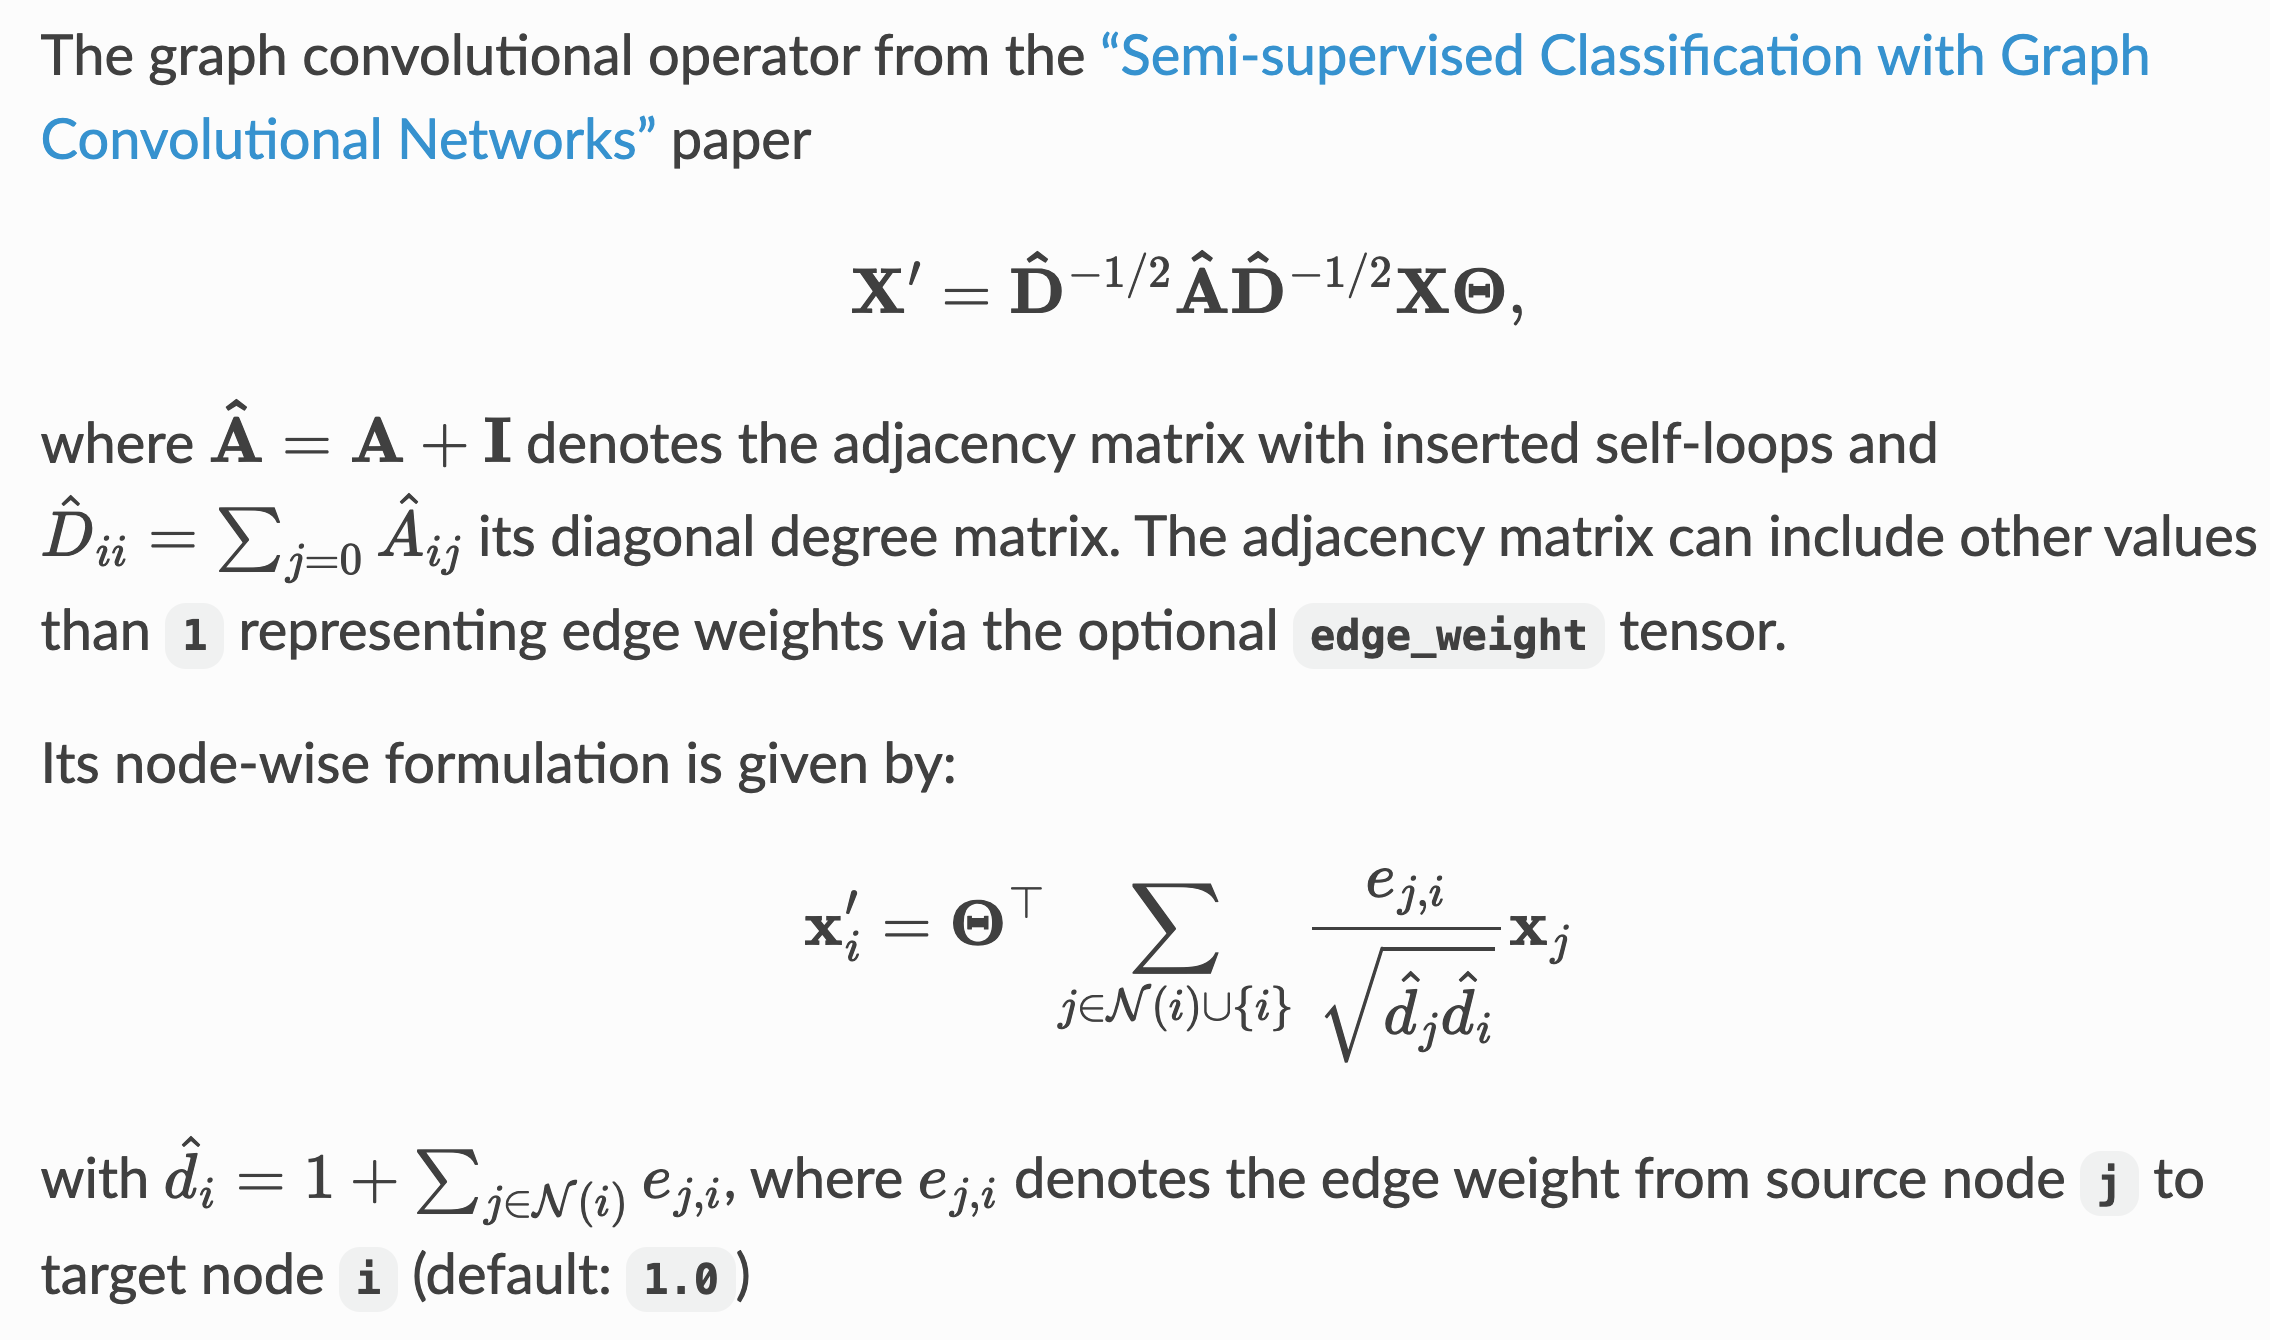
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

여기에서

1.  ${\bf A}$는 연결정보를 의미
2.  $\hat{\bf A}$는 연결정보에 자기자신의 노드를 추가
3.  ${\bf D}$는 ${\bf A}$를 표준화하기 위한 매트릭스
4.  결국 $\hat{\bf D}^{-1/2}\hat{\bf A}\hat{\bf D}^{-1/2}$ 는 통째로
    연결정보에 대한 matrix
5.  $\hat{\bf D}^{-1/2}\hat{\bf A}\hat{\bf D}^{-1/2}{\bf X}$ 는 통째로
    ${\bf X}$를 평행이동한것을 의미 (혹은 그 비슷한 것을 의미)
6.  ${\bf \Theta}$는 weight를 곱하는 과정임

Kipf, Thomas N, and Max Welling. 2016. “Semi-Supervised Classification
with Graph Convolutional Networks.” *arXiv Preprint arXiv:1609.02907*.